In [1]:
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
# Load the pre-trained DINO ViT model
vits8 = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
vits8.eval()
#print(vits8)

Using cache found in /Users/rohitpotdukhe/.cache/torch/hub/facebookresearch_dino_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [3]:
# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

#Load your unlabeled dataset
unlabeled_dataset = datasets.ImageFolder('/Users/rohitpotdukhe/Desktop/Dataset/', transform=transform)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)

In [4]:
# Extract features
features = []
with torch.no_grad():
    for inputs, _ in unlabeled_loader:
        outputs = vits8(inputs)
        features.extend(outputs.cpu().numpy())

features = np.array(features)

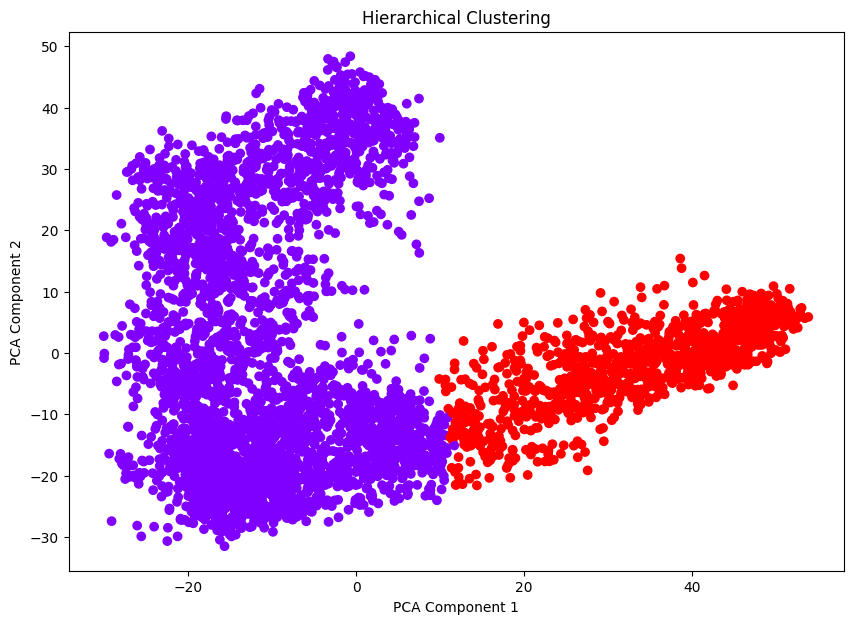

In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Perform clustering
n_clusters = 2  # Define the number of clusters
clustering = AgglomerativeClustering(n_clusters=n_clusters)
pseudo_labels_aggClust = clustering.fit_predict(reduced_features)

# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=pseudo_labels_aggClust, cmap='rainbow')
plt.title("Hierarchical Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [6]:
from sklearn.cluster import KMeans

# Perform clustering
n_clusters = 2  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters)
pseudo_labels = kmeans.fit_predict(features)

/Users/rohitpotdukhe/venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


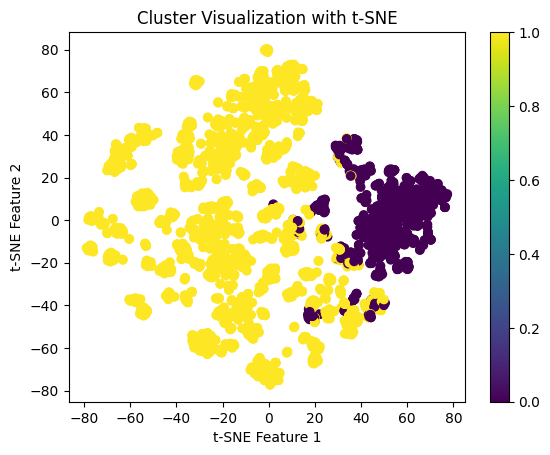

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Visualize clusters using t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(features)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=pseudo_labels)
plt.title('Cluster Visualization with t-SNE')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar()
plt.show()

In [8]:
# Load labeled dataset
labeled_dataset = datasets.ImageFolder('/Users/rohitpotdukhe/Desktop/val', transform=transform)
labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=32, shuffle=True)

# Testing Logic (Assuming Binary Classification)
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in labeled_loader:
        outputs = vits8(inputs)
        predicted = kmeans.predict(outputs.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.numpy()).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the labeled test dataset: {accuracy}%')

Accuracy on the labeled test dataset: 46.883005977796756%


In [6]:
# Load labeled dataset
labeled_dataset = datasets.ImageFolder('/Users/rohitpotdukhe/Desktop/val', transform=transform)
labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=32, shuffle=True)

# Testing Logic (Assuming Binary Classification)
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in labeled_loader:
        outputs = vits8(inputs)
        predicted = kmeans.predict(outputs.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.numpy()).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the labeled test dataset: {accuracy}%')

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

In [7]:
from sklearn.metrics import accuracy_score

# Load labeled dataset
labeled_dataset = datasets.ImageFolder('/Users/rohitpotdukhe/Desktop/val', transform=transform)
labeled_loader = torch.utils.data.DataLoader(labeled_dataset, batch_size=32, shuffle=True)

# Testing Logic (Assuming Binary Classification)
features = []  # To store the features
true_labels = []  # To store the true labels

# Extract features and true labels
with torch.no_grad():
    for inputs, labels in labeled_loader:
        outputs = vits8(inputs)
        features.extend(outputs.cpu().numpy())
        true_labels.extend(labels.numpy())

# Agglomerative Clustering
clustering = AgglomerativeClustering(n_clusters=2)
predicted_labels = clustering.fit_predict(features)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy on the labeled test dataset: {accuracy * 100}%')

Accuracy on the labeled test dataset: 54.654141759180185%
